In [1]:
import numpy as np

<!-- Algoritmo de detección de bloques en una matriz

1. Para cada renglón obtener índice tal que todos a la derecha son 0 y todos a la izquierda de la diagonal son cero 
2. Para todas las columnas entre esos valores revisar hasta donde llegan hacia abajo y tomar el máximo.
3. Revisar que todos los renglones en ese rango  -->

# Probabilidades de absorción problema del apostador



In [3]:

def gen_matriz(N, p):
    # Inicializa una matriz de (N+1) x (N+1) llena de ceros
    matrix = np.zeros((N+1, N+1))

    # Estados absorbentes
    matrix[0, 0] = 1
    matrix[N, N] = 1

    # Rellenamos los elementos a cada lado de la diagonal
    for i in range(1, N):
        matrix[i, i-1] = 1 - p  # Probabilidad de perder
        matrix[i, i+1] = p  # Probabilidad de ganar

    return matrix

def simula_dado_pi(pi):
    # Primero simulamos uniforme
    u=np.random.random()
    # print(u)
    # después vemos en que cubeta cae y devolvemos esa variable aleatoria
    mask=u < pi.cumsum()
    
    var_aleatoria=mask.argmax()
    return var_aleatoria

def cadena_jugador_absorcion(X_0,N=10,p=0.5):
    '''
    función que simula una cadena del problema del apostador hasta que llega a un estado absorbente
    X_0 es el estado inicial
    N: dimensión del problema del jugador
    p: probabilidad de ganar 1 peso (1-p probabilidad de perder un peso)
    '''

    Pij = gen_matriz(N, p)

    pi=np.zeros(N+1)
    pi[X_0]=1

    Xn=[]
    absorcion=False 

    while not absorcion:
        # Simulamos de la distribución pi_i
        Xi=simula_dado_pi(pi)
        # Guardamos el valor en una lista
        Xn.append(Xi)

        if Xi==0 or Xi==N:
            absorcion=True

        # Actualizamos la probabilidad del siguiente paso

        # Inicializamos un vector de probabilidad que tiene ceros en todas las coordenadas
        pi=np.zeros(N+1)
        # Ponemos el índice de la simulación en 1. Para tener un vector de probabilidades que siempre cae en Xi
        pi[Xi]=1
        # Actualizamos la probabilidad de caer en el siguient estado
        pi=pi@Pij

    return Xn


cadena_jugador_absorcion(1)

[1, 0]

Probabilidad de absorción está dada por $$ \rho_C=\mathbb{P}\left[ T_C <\infty \right] $$

Donde $C$ es una clase de comunicación de recurrentes (cerrada e irreducible)

Si partimos desde $X_0 \in S_R$, es decir desde un recurrente entonces pasa una de las siguientes cosas
1. Si pertenece a la misma clase de comunicación, tenemos en cuyo caso $T_c=0\rightarrow \rho_C =1$
2. Pertenece a otra clase de comunicación de recurrentes $D\neq C$, en cuyo caso $T_C=\infty, \rho_C=0$

Entonces el único caso interesante es partir de un transitorio. Podemos simular esta cantidad haciendo $n$ experimentos y ver cuándo se absorbe por el 0 y cuando se absorbe por el 10


In [4]:
# Creamos un diccionario que va a almacenar las proporciones de absorción por cada estado
# La llave 0 tiene como valor un arreglo donde almacenaremos la proporción de veces que el estado i se absorbió por el 0
# De manera análoga para la llave 10 y la llave otro es por si no termina en algun estado absorbente

dicc_cuentas={0:np.zeros(11),10:np.zeros(11),'otro':np.zeros(11)}
p=0.5

N_simul=10_000
for X0 in range(11):
    for _ in range(N_simul):
        ultimo_estado=cadena_jugador_absorcion(X_0=X0,p=p)[-1]
        if ultimo_estado not in [0,10]:
            dicc_cuentas['otro'][X0]+=1/N_simul
        else:
            dicc_cuentas[ultimo_estado][X0]+=1/N_simul

dicc_cuentas

{0: array([1.    , 0.9037, 0.7989, 0.6997, 0.5984, 0.4961, 0.4003, 0.294 ,
        0.2016, 0.0972, 0.    ]),
 10: array([0.    , 0.0963, 0.2011, 0.3003, 0.4016, 0.5039, 0.5997, 0.706 ,
        0.7984, 0.9028, 1.    ]),
 'otro': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

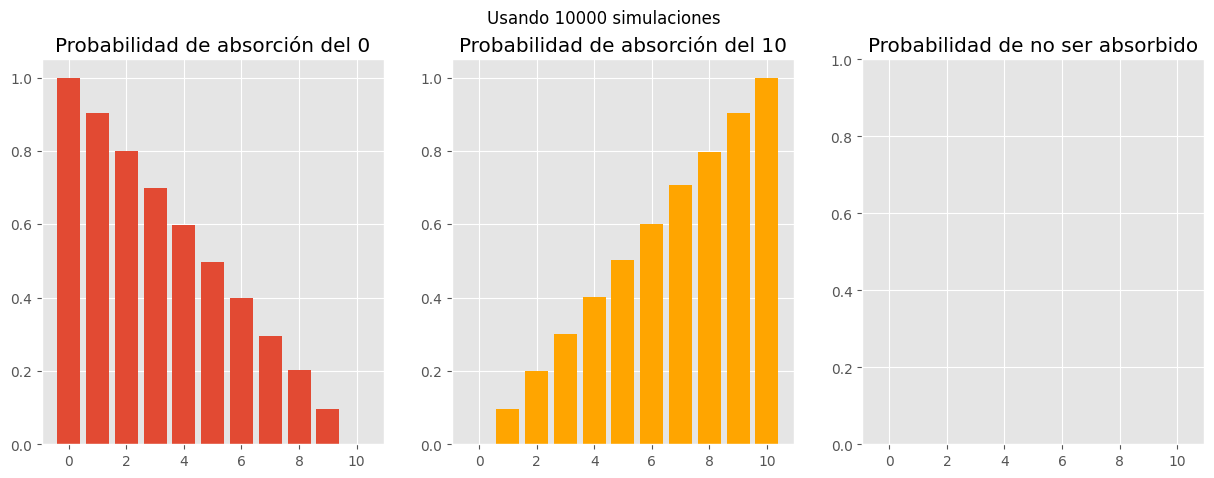

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,5))
ax[0].bar(x=np.arange(11),height=dicc_cuentas[0])
ax[0].set_title('Probabilidad de absorción del 0')

ax[1].bar(x=np.arange(11),height=dicc_cuentas[10],color='orange')
ax[1].set_title('Probabilidad de absorción del 10')

ax[2].bar(x=np.arange(11),height=dicc_cuentas['otro'],color='green')
ax[2].set_ylim(0,1)
ax[2].set_title('Probabilidad de no ser absorbido')

fig.suptitle(f'Usando {N_simul} simulaciones')
plt.show()

Esto se debe a que la probabilidad de transición de absorción al, por ejemplo, 0, dado que empezamos en $X_0=i$ está dada por

$$ 
\begin{align}
{P}_i\left( T_0 <\infty  \right)&=\mathbb{P}\left[ T_0< \infty| X_0=i \right]\\
&=(1-p) P_{i-1}\left( T_0 <\infty  \right)+ p P_{i+1}\left( T_0 <\infty  \right)
\end{align}
$$

con los casos especiales de $P_0\left( T_0 <\infty  \right)=1, P_{N}\left( T_0 <\infty  \right)=0$

Tomando la notación ${P}_i\left( T_0 <\infty  \right)=\mathcal{P}_i$, tenemos el siguiente sistema de ecuaciones
$$ 
\begin{align}
\mathcal{P}_0&=1\\
\mathcal{P}_1-(1-p)\mathcal{P}_0-p \mathcal{P}_2&=0\\
\mathcal{P}_2-(1-p)\mathcal{P}_1-p \mathcal{P}_0&=0\\
&\vdots\\
\mathcal{P}_{N-1}-(1-p)\mathcal{P}_{N-2}-p \mathcal{P}_N&=0\\
\mathcal{P}_N&=0
\end{align}
$$

que se resuelve a 

$$
\mathcal{P}_i = 1-\frac{1 - \left( \frac{1-p}{p} \right)^i}{1 - \left( \frac{1-p}{p} \right)^N}
$$

Como se tiene que absorber por el 0 o por el $N$ obtenemos la siguiente probabilidad de absorción para el $N$, denotada por $\mathcal{Q}$

$$
\mathcal{Q}_i = 1-\mathcal{P}_i=\frac{1 - \left( \frac{1-p}{p} \right)^i}{1 - \left( \frac{1-p}{p} \right)^N}
$$

que para 1/2 tiene el valor de $\mathcal{Q}_i=\frac{i}{n}$

# Cadena de ramificación

¿Cuántas generaciones tardan para que se pierda un apellido? 

- Podemos modelar esto como un proceso que empieza con los primeros López
- En cada paso tomamos en cuenta una distribución de probabilidad $f(x_i)$ sobre el número de hijos varones (porque estos propagan el apellido). 
- Para que sea un proceso estacionario vamos a asumir que la probabilidad de tener hijos varones a permanecido igual a través del tiempo

Así podemos definir una cadena de Markov tal que 

$$ 
\begin{align}
X_0&=\text{Numero inicial de López}\\
X_1&=\text{Numero de López en la segunda generación}\\
&\vdots\\
X_n&=\text{Numero de López en la generación } n+1\\
&\vdots
\end{align}
$$


¿Esta cadena tiene un estado absorbente? ¿Cuál es?

Para calcular la probabilidad de absorción desde un estado con valor $k$ basta conocer la probabilidad de absorción comenzando con una persona $\rho_{10}$ ya que en cualquier estado sólo con $k>1$ tendríamos que tener que $k$ estados de una persona se extinguieran. Así la probabilidad de absorción desde $k$ es $$\rho_{k0}={\rho_{10}}^k$$

Supongamos que tenemos datos de los índices de varones de los López y está dado por la siguiente distribución

1.0


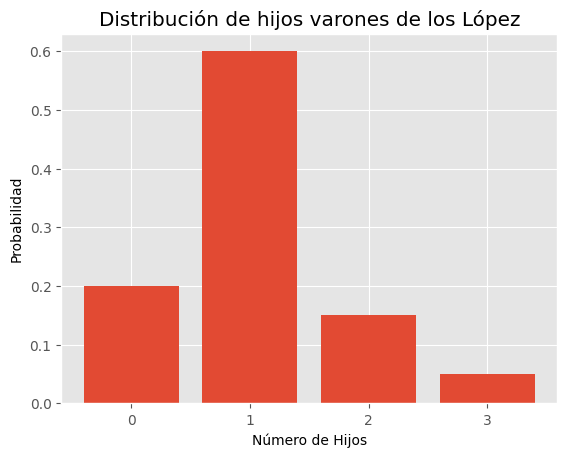

In [45]:
distr_hijos=np.array([0.2,0.6,0.15,0.05])
print(distr_hijos.sum())
plt.bar(np.arange(len(distr_hijos)),distr_hijos)
plt.title('Distribución de hijos varones de los López')
plt.xticks(ticks=np.arange(len(distr_hijos)),labels=np.arange(len(distr_hijos)))
plt.xlabel('Número de Hijos');plt.ylabel('Probabilidad');plt.show()

¿Cómo haríamos para estimar las generaciones en las que se acabarán los López, dado que ahora hay $N$ López varones en el mundo?

Estimamos la probabilidad de absorción para 0. La otra posibilidad es que nunca se acaben los López. 

Entonces simularemos la cadena de Markov, pondremos una cota superior y si en ese momento no se han acabado supondremos que en esa simulación hubo infinitos López

In [63]:
X_0=2
import networkx as nx
G=nx.DiGraph()
def cadena_ramificaciones(X_0,N_cadena,distr_hijos):
    cadena=[X_0]
    for generacion in range(N_cadena):
        Xi=0
        for padres in range(cadena[-1]):
            Xi+=simula_dado_pi(distr_hijos)
        cadena.append(Xi)

    return cadena

N_simul=1_000
absorbio_lista=[]
for _ in range(N_simul):
    absorbio_lista.append(0 in cadena_ramificaciones(X_0=1,N_cadena=100,distr_hijos=distr_hijos))

rho_00_est=sum(absorbio_lista)/N_simul
rho_00_est

0.823

Etonces la probabilidad de absorción al 0 desde el 1 la estimamos como el $82\%$ y tenemos que la posibilidad de extinción para $N$ lopez está dada por 

$.82^N$

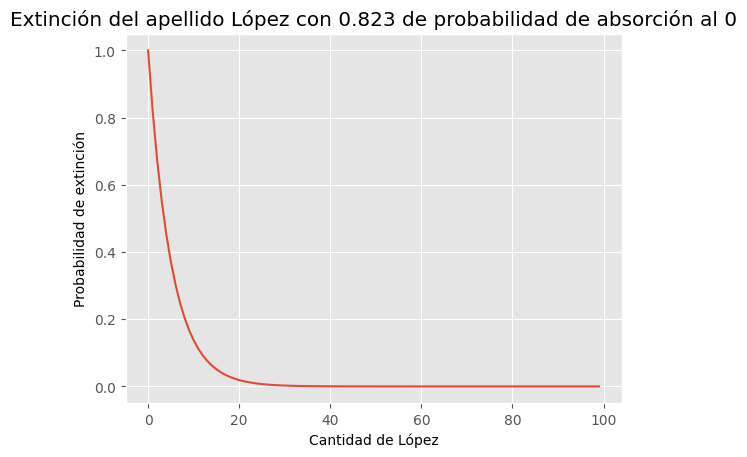

In [68]:
plt.title(f'Extinción del apellido López con {rho_00_est} de probabilidad de absorción al 0')
plt.xlabel('Cantidad de López'); plt.ylabel('Probabilidad de extinción')
plt.plot((0.82)**np.arange(0,100))
plt.show()